In [1]:
import struct
import numpy as np
import matplotlib.pyplot as plt

def read_idx_images(path):
    with open(path, 'rb') as f:
        _, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    return data

def read_idx_labels(path):
    with open(path, 'rb') as f:
        _, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for _ in range(dims))
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

In [ ]:
# def isomap(X, k=5, d=2):
#     n = X.shape[0]

#     # step 1: full paiwise euclid distances
#     D0 = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)

#     # step 2: build k-NN graph 
#     G = np.full((n, n), np.inf)
#     np.fill_diagonal(G, 0.0)
#     for i in range(n):
#         neigh = np.argsort(D0[i])[1:k+1] # k nearest neighbors
#         G[i, neigh] = D0[i, neigh]
#         G[neigh, i] = D0[i, neigh]  

#     # step 3: compute shortest paths (floyd-warshall)
#     D = G.copy()
#     for m in range(n):
#         D = np.minimum(D, D[:, m, None] + D[None, m, :])

#     # step 4: calcuate embedding
#     D2 = D ** 2
#     H = np.eye(n) - np.ones((n, n)) / n
#     B = -0.5 * H.dot(D2).dot(H)

#     # step 5: eigen decomposition
#     eigvals, eigvecs = np.linalg.eigh(B)
#     idx = np.argsort(eigvals)[::-1]
#     L = np.diag(np.sqrt(np.maximum(eigvals[idx[:d]], 0)))
#     V = eigvecs[:, idx[:d]]
#     Y = V.dot(L)
#     return Y

In [7]:
def pairwise_distances(X):
    """
    Compute the full NxN Euclidean distance matrix
    without ever allocating an N×N×D temporary.
    """
    # squared norms of each row
    sq = np.sum(X*X, axis=1)                   # shape (N,)
    # use (a - b)^2 = a^2 + b^2 - 2ab
    D2 = sq[:, None] + sq[None, :] - 2*X.dot(X.T)
    np.maximum(D2, 0, out=D2)                  # kill tiny negatives
    return np.sqrt(D2)                         # shape (N,N)

def isomap(X, k=10, d=2):
    n = X.shape[0]

    # Step 1: pairwise distances
    D0 = pairwise_distances(X)

    # Step 2: build k-NN graph
    G = np.full((n, n), np.inf)
    np.fill_diagonal(G, 0.0)
    for i in range(n):
        neigh = np.argsort(D0[i])[1:k+1]
        G[i, neigh] = D0[i, neigh]
        G[neigh, i] = D0[i, neigh]

    # Step 3: shortest paths (Floyd–Warshall)
    D = G.copy()
    for m in range(n):
        # vectorized row/col update
        D = np.minimum(D, D[:, m, None] + D[None, m, :])

    # Step 4: classical MDS on geodesic D
    D2 = D**2
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H.dot(D2).dot(H)

    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    vals = eigvals[idx[:d]]
    vecs = eigvecs[:, idx[:d]]
    Y = vecs * np.sqrt(vals)                  # broadcast scale columns
    return Y

In [12]:
images = read_idx_images('mnist/train-images-idx3-ubyte')
labels = read_idx_labels('mnist/train-labels-idx1-ubyte')

N = 1000
X = images[:N].reshape(N, -1).astype(float) / 255.0
y = labels[:N]

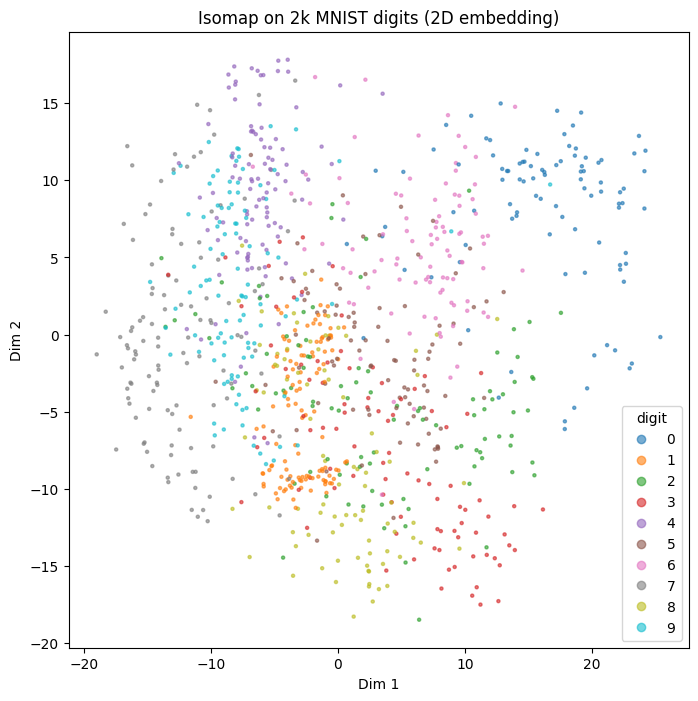

In [13]:
Y2 = isomap(X, k=10, d=2)
plt.figure(figsize=(8,8))
scatter = plt.scatter(Y2[:,0], Y2[:,1], c=y, cmap='tab10', s=5, alpha=0.6)
plt.title("Isomap on 2k MNIST digits (2D embedding)")
plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.legend(*scatter.legend_elements(), title="digit")
plt.show()